In [90]:
import pickle
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [91]:
#Setup Distrbuited training
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

Resolution = 100
X = X/255.0

with strategy.scope():      #Enables multi-gpu
    model = Sequential([
        
        Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu', input_shape=(Resolution, Resolution, 1)),
        MaxPooling2D((1, 5), strides=(4)),
        
        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D((1, 4), strides=(3)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D((1, 2), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D((2, 2), strides=(2)),
        
        Flatten(),
        Dense(32, activation='relu',kernel_regularizer=regularizers.l2()),
        Dense(6, activation='softmax')
    ])



model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(),                  #gradient descent
              metrics=['accuracy'])

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 100, 100, 32)      320       
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 25, 24, 32)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 25, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 9, 7, 32)          0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 9, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 5, 3, 32)          0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 5, 3, 32)        

In [93]:
history = model.fit(X, y, batch_size=20, epochs=100, validation_split=0.2)

Epoch 1/100
48/48 [==============================] - 2s 20ms/step - loss: 2.1681 - accuracy: 0.1566 - val_loss: 2.0365 - val_accuracy: 0.1667
Epoch 2/100
48/48 [==============================] - 1s 15ms/step - loss: 2.0054 - accuracy: 0.1735 - val_loss: 1.9267 - val_accuracy: 0.1667
Epoch 3/100
48/48 [==============================] - 1s 15ms/step - loss: 1.9080 - accuracy: 0.1820 - val_loss: 1.8621 - val_accuracy: 0.1667
Epoch 4/100
48/48 [==============================] - 1s 15ms/step - loss: 1.8489 - accuracy: 0.1901 - val_loss: 1.7962 - val_accuracy: 0.3458
Epoch 5/100
48/48 [==============================] - 1s 15ms/step - loss: 1.7525 - accuracy: 0.2832 - val_loss: 1.8152 - val_accuracy: 0.1667
Epoch 6/100
48/48 [==============================] - 1s 15ms/step - loss: 1.5931 - accuracy: 0.2632 - val_loss: 1.3900 - val_accuracy: 0.3125
Epoch 7/100
48/48 [==============================] - 1s 15ms/step - loss: 1.4012 - accuracy: 0.3344 - val_loss: 1.3730 - val_accuracy: 0.4917
Epoch 

38/38 - 1s - loss: 0.1018 - accuracy: 0.9767


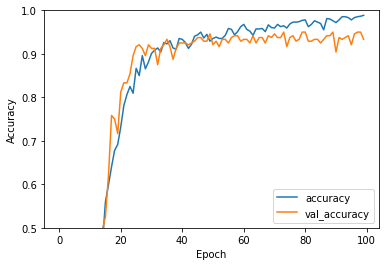

In [94]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X,  y, verbose=2)